## Introduction

The goal of this study is to understand determinants of crime in North Carolina given a dataset from 1987, and recommend a policy to help reduce the crime rate. Our research questions is: "Which factors increase the crime rate?" We need to determine which covariates affect the crime rate (crmrte) the most, making it our dependent variable. 

In [1]:
#Install required packages
install.packages("car")
install.packages("lmtest")
install.packages("sandwich")
install.packages("imputeTS")
install.packages("stargazer")
install.packages("effsize")
install.packages("sandwich")
install.packages("QuantPsyc")


The downloaded binary packages are in
	/var/folders/14/0286vgm17ynbvnkzv81_5hvh0000gn/T//RtmpK8jknK/downloaded_packages

The downloaded binary packages are in
	/var/folders/14/0286vgm17ynbvnkzv81_5hvh0000gn/T//RtmpK8jknK/downloaded_packages

The downloaded binary packages are in
	/var/folders/14/0286vgm17ynbvnkzv81_5hvh0000gn/T//RtmpK8jknK/downloaded_packages

The downloaded binary packages are in
	/var/folders/14/0286vgm17ynbvnkzv81_5hvh0000gn/T//RtmpK8jknK/downloaded_packages

The downloaded binary packages are in
	/var/folders/14/0286vgm17ynbvnkzv81_5hvh0000gn/T//RtmpK8jknK/downloaded_packages

The downloaded binary packages are in
	/var/folders/14/0286vgm17ynbvnkzv81_5hvh0000gn/T//RtmpK8jknK/downloaded_packages

The downloaded binary packages are in
	/var/folders/14/0286vgm17ynbvnkzv81_5hvh0000gn/T//RtmpK8jknK/downloaded_packages

The downloaded binary packages are in
	/var/folders/14/0286vgm17ynbvnkzv81_5hvh0000gn/T//RtmpK8jknK/downloaded_packages


In [2]:
#Import libraries
library(car)
library(lmtest)
library(sandwich)
library(effsize)
library(imputeTS)
library(stargazer)
library(sandwich)
library(QuantPsyc)

Loading required package: carData
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff

Attaching package: ‘imputeTS’

The following object is masked from ‘package:zoo’:

    na.locf


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 

Loading required package: boot

Attaching package: ‘boot’

The following object is masked from ‘package:car’:

    logit

Loading required package: MASS

Attaching package: ‘QuantPsyc’

The following object is masked from ‘packa

First, we will load the data set and do some initial cleaning. 

In [3]:
#Import dataframe
df <- read.csv("crime_v2.csv")
df <- na.omit(df) #removes empty rows at the end. 

## Data Cleaning
First, we convert probability of conviction (prbconv) to numeric, remove the year since it is constant, remove a duplicate row, set county to be the index and remove it.

In [4]:
df$prbconv = as.numeric(as.character(df$prbconv))
crime = subset(df, select = -year)
crime = crime[-88,]
rownames(crime) <- crime$county
crime$county <- NULL

An initial analysis of the histograms and distribution of the data helps us to determine which variables need to be transformed in any manner. We are not going to show this in the report because it is a lot of graphs, but uncommenting and running this code will show them. 

In [5]:
#create histograms
# for (col in 1:ncol(crime)) {
#   hist(crime[,col], main = names(crime)[col])
# }

#create scatterplots
# for (col in 1:ncol(crime)) {
#   plot(crime$crmrte~ crime[,col], main = names(crime)[col])
# }


These histograms and scatterplots revealed some unusual data points and skewed distributions. We will do some clean up of the data and then re-check the histograms. First, wage for service industry (wser) has a point that is 10 times greater than most. We divide this point by 10 because we think the decimal was put in the wrong place.

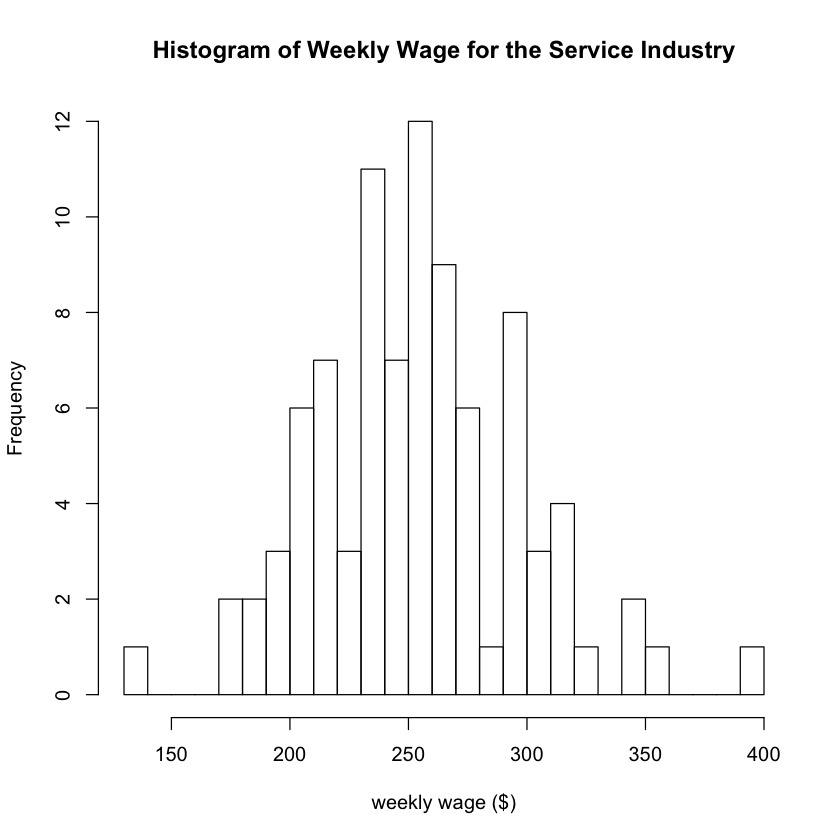

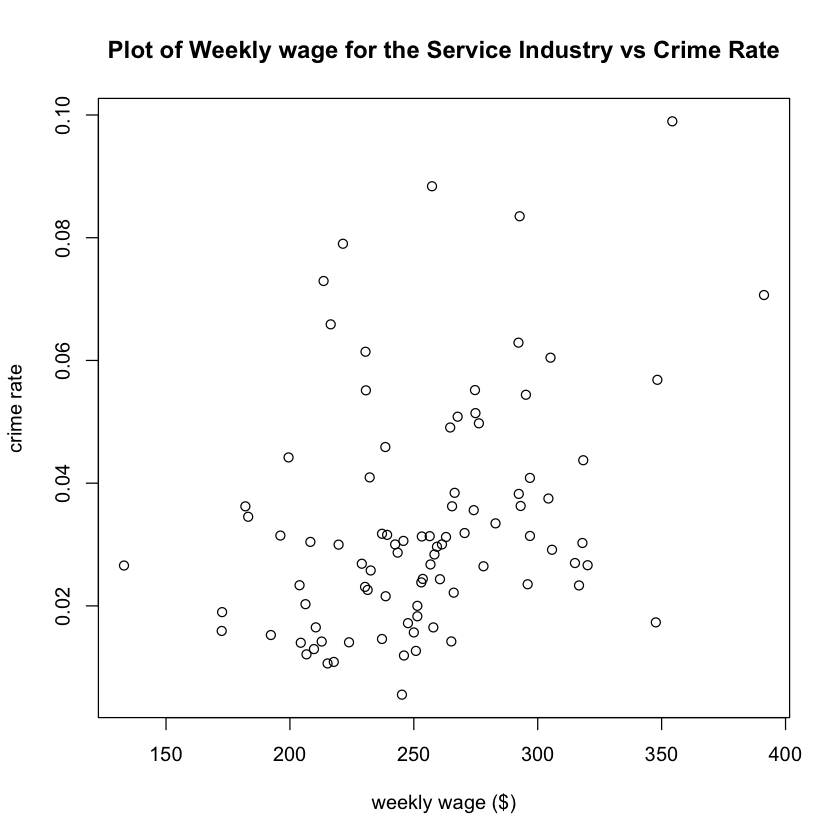

In [6]:
row_10x_wser <- which(df$wser>2000)
crime$wser[row_10x_wser] <- crime$wser[row_10x_wser]/10
hist(crime$wser, main= "Histogram of Weekly Wage for the Service Industry", xlab="weekly wage ($)", breaks = 20)
plot(crime$crmrte ~ crime$wser, main = "Plot of Weekly wage for the Service Industry vs Crime Rate", 
     xlab="weekly wage ($)", ylab="crime rate")

After correcting this value we can see that the historgram is quite symmetrical. The scatter plot indicates a weak, positive relationship between the service wage and crime, which is somewhat surprising.

A particular county seems to have a probability of arrest greater than 1, which is impossible. Since we cannot determine the true probability of arrest and the rest of the row provides valuable data, we are going to impute the mean for this variable in its place. This will reduce the variance, but the effect should be slight enough to be negligible while also retaining the other data points. 

In [7]:
invalid_prbarr <- which(crime$prbarr > 1)
mean_prbarr <- mean(crime[-invalid_prbarr,]$prbarr)
crime$prbarr[invalid_prbarr] = mean_prbarr

Similarly, 10 rows have probability of conviction greater than 1, which is not a valid probability. We have replaced these values with the means as well.

In [8]:
summary(crime$prbconv)

rem_list <- list(which(crime$prbconv >= 1)) # it is rows 2 10 44 51 56 61 67 84 89 90 

for (col in rem_list) {
  crime$prbconv[col] = NA
}

mean_prbconv = mean(crime$prbconv, na.rm=TRUE)
crime$prbconv <- ifelse(is.na(crime$prbconv), mean_prbconv, crime$prbconv)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06838 0.34422 0.45170 0.55086 0.58513 2.12121 

The police per capita variable appears to have an outlier.

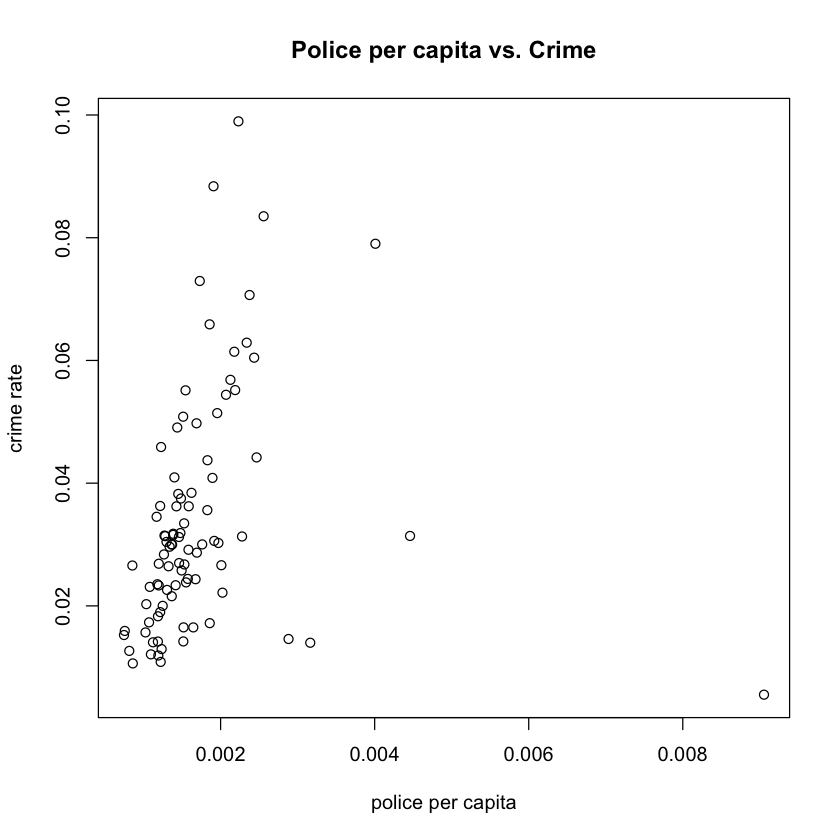

In [9]:
plot(crime$crmrte ~ crime$polpc, main = "Police per capita vs. Crime", xlab="police per capita", ylab="crime rate")

In [10]:
which(crime$polpc > .009) 

[1] 51

This point also had a probability of arrest greater than 1, a percent minority greater than 1, and an average sentence that was much higher than other points. We think data point 51 has been tampered with and we are throwing it out.

In [11]:
crime = crime[-51,]

Percent young male and tax revenue per capita have outliers. At this time, we cannot justify doing anything with the taxpc or pctmle based on our EDA in the graphs below. But, they may have high leverage and need to be removed later. We should look at models with and without these points to make a final call. 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  25.69   30.85   34.96   38.27   41.07  119.76 

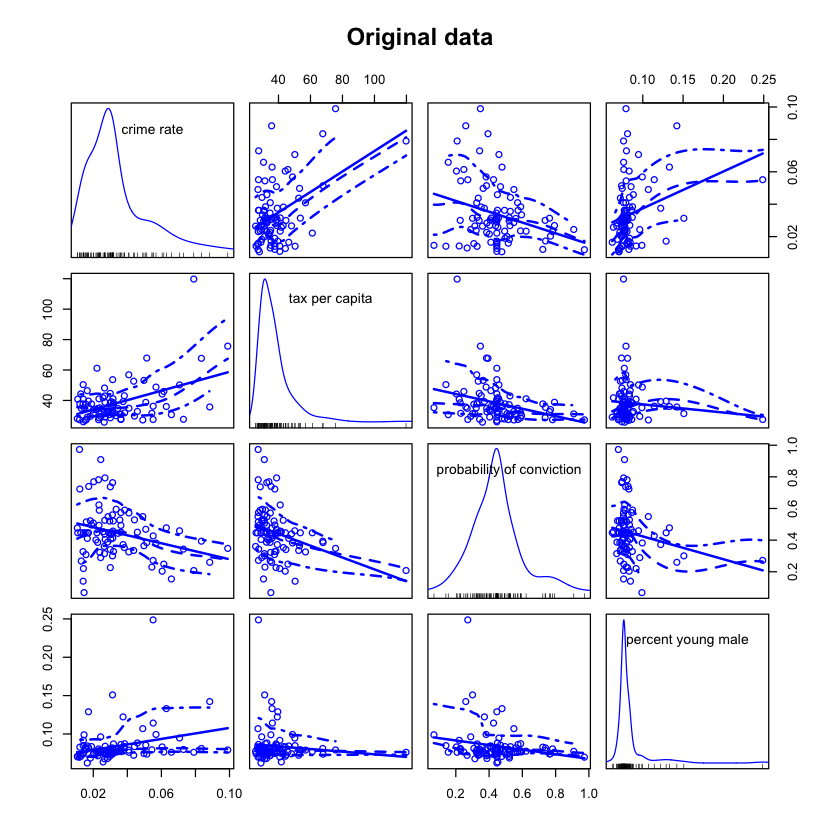

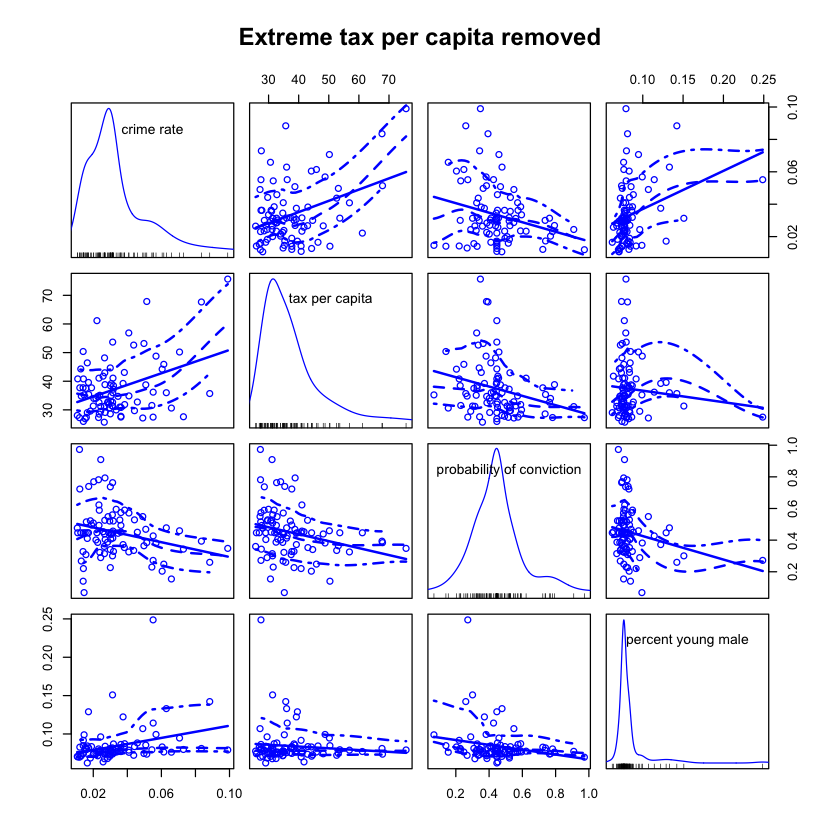

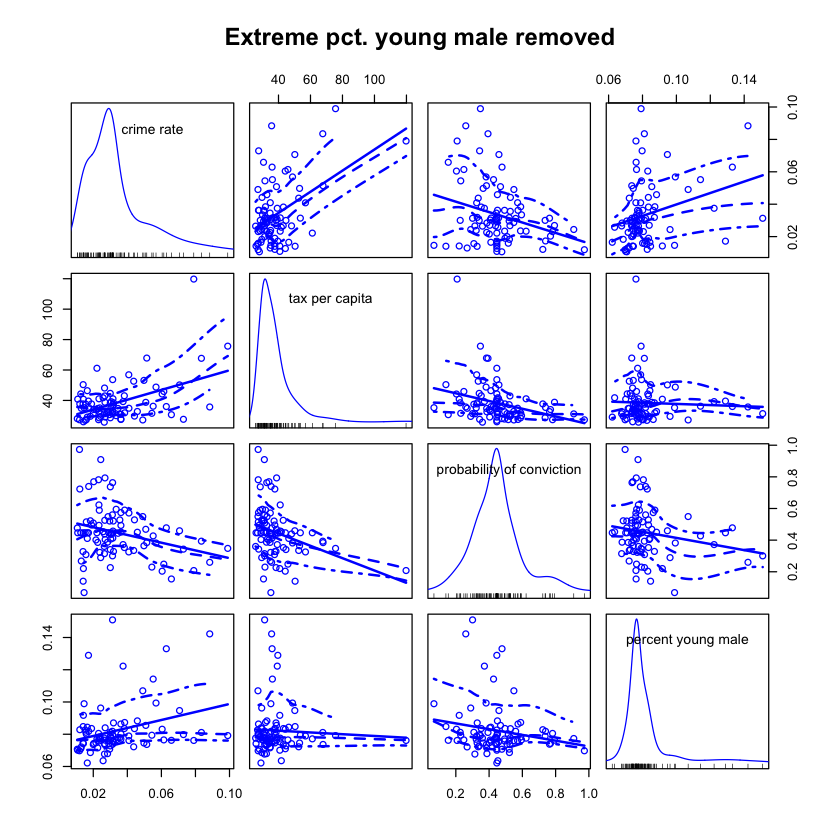

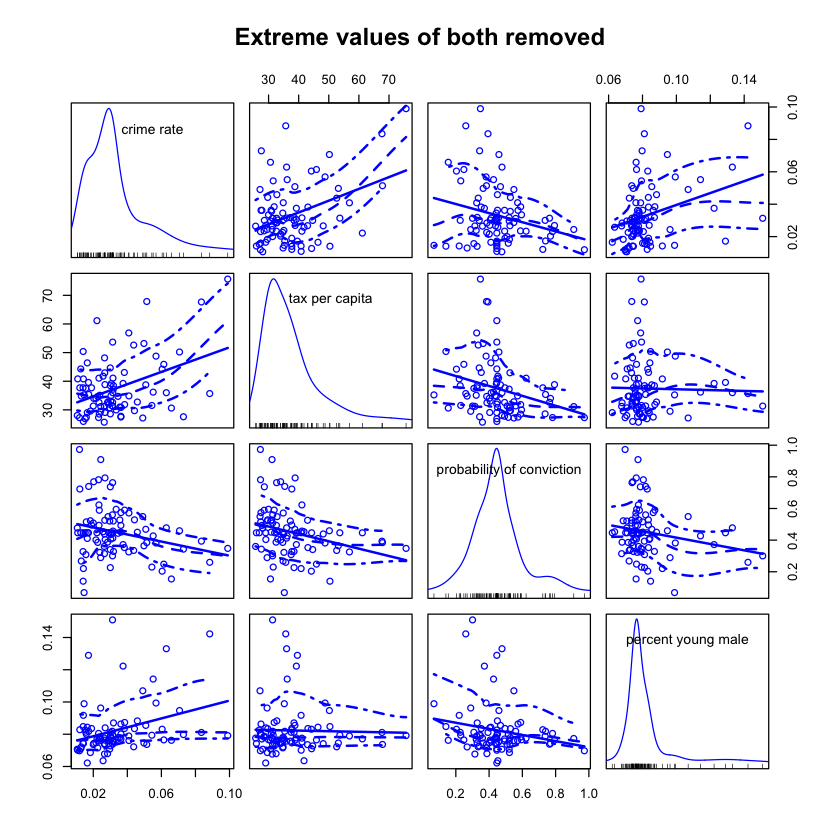

In [12]:
summary(crime$taxpc)
scm_labels <- c("crime rate","tax per capita","probability of conviction","percent young male")
scatterplotMatrix(~crmrte + taxpc + prbconv + pctymle, data = crime, main="Original data", var.labels=scm_labels)
scatterplotMatrix(~crmrte + taxpc + prbconv + pctymle, data = crime[-25,], main="Extreme tax per capita removed", var.labels=scm_labels)
scatterplotMatrix(~crmrte + taxpc + prbconv + pctymle, data = crime[-58,], main="Extreme pct. young male removed", var.labels=scm_labels)
scatterplotMatrix(~crmrte + taxpc + prbconv + pctymle, data = crime[-c(25,58),], main="Extreme values of both removed", var.labels=scm_labels)

From these graphs, we see that there are potentially problematic points but we cannot justify removing the data at this time.

We examine the cleaned plots to determine if anything changed and what further actions need to be taken. 

In [13]:
sum(is.na(crime)) #No missing values
# for (col in 1:ncol(crime)) {
#   hist(crime[,col], main = names(crime)[col])
# }

# for (col in 1:ncol(crime)) {
#   plot(crime$crmrte~ crime[,col], main = names(crime)[col])
# }

[1] 0

The following variables appear to have skewed data based on our EDA, and would therefore benefit from taking the log of the values: Crime rate (crmrte), Police per capital (polpc), Population density (density), Tax per capita (taxpc), Crime mix (mix), and Percent young male (pctymle). We create a new dataset with these variables transformed and relabled them with a log indicator.

In [14]:
logcrime = crime
logcrime$crmrte = log(crime$crmrte)
logcrime$polpc = log(logcrime$polpc)
logcrime$density = log(logcrime$density)
logcrime$taxpc = log(logcrime$taxpc)
logcrime$mix = log(logcrime$mix)
logcrime$pctymle = log(logcrime$pctymle)

colnames(logcrime)[1] = "log_crmrte"
colnames(logcrime)[6] = "log_polpc"
colnames(logcrime)[7] = "log_density"
colnames(logcrime)[8] = "log_taxpc"
colnames(logcrime)[22] = "log_mix"
colnames(logcrime)[23] = "log_pctymle"

For each variable, we once again examined the histogram of the log of the data and the scatterplot with crime rate to ensure the transformation worked as expected.

In [15]:
# for (col in 1:ncol(logcrime)) {
#   hist(logcrime[,col], main = names(logcrime)[col])
# }

# for (col in 1:ncol(logcrime)) {
#   plot(logcrime$log_crmrte~ logcrime[,col], main = names(logcrime)[col])
# }

In the scatterplot matrix below, we compared the log data to the regular data. The log data appears to be more linear for each item when compared to crime rate, and less heteroskedastic. After taking the log of "mix" and "crmrte", there appears to be little correlation there. 

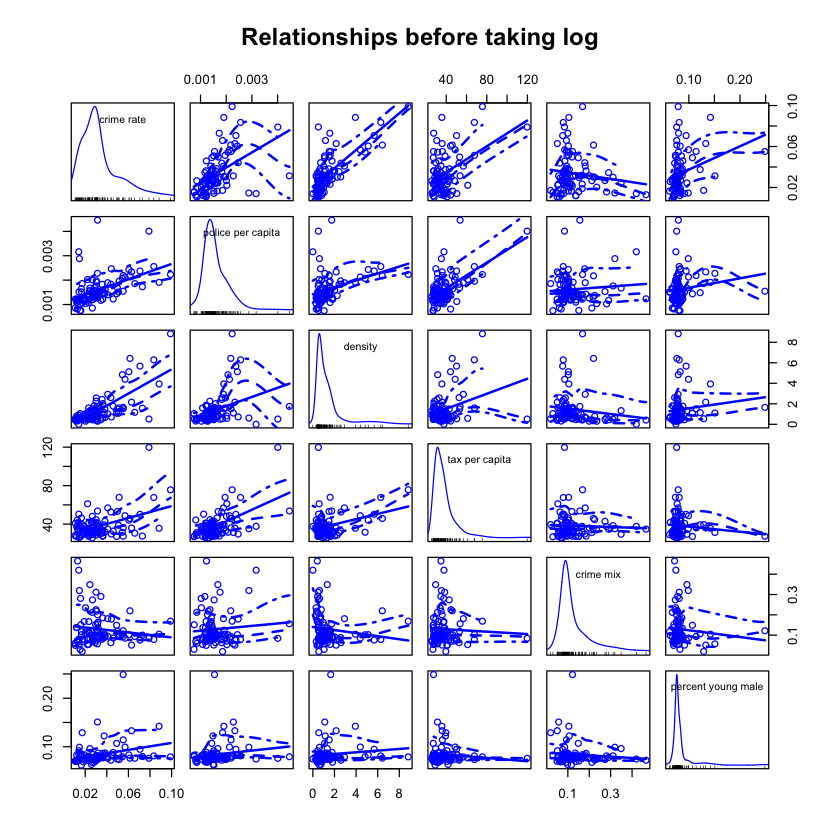

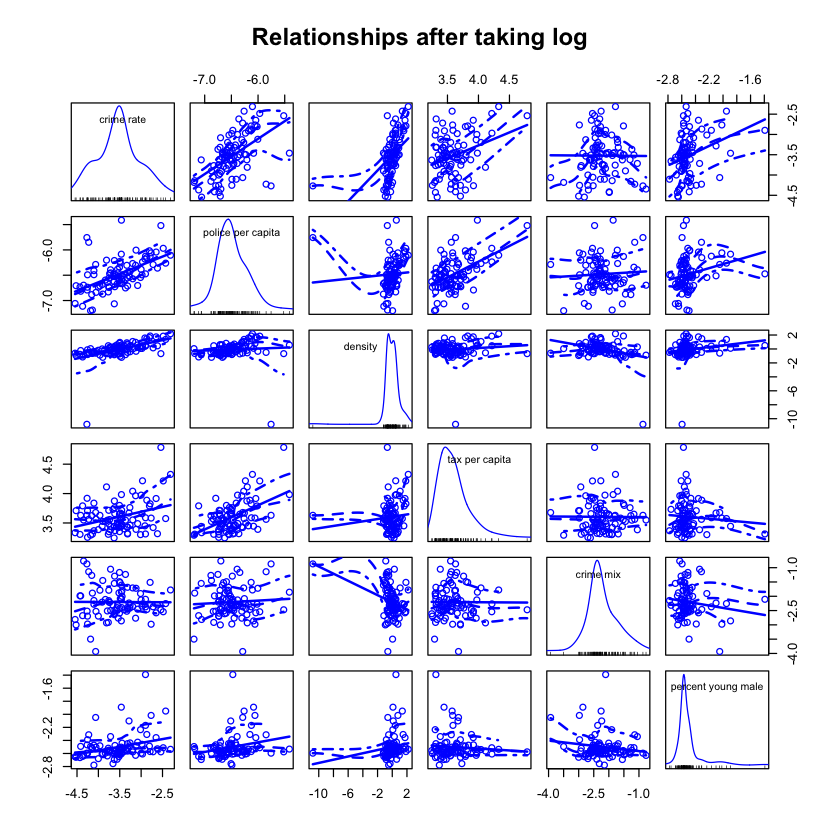

In [16]:
scm_labels <- c("crime rate","police per capita","density","tax per capita", "crime mix", "percent young male")
scatterplotMatrix(~crmrte +polpc + density + taxpc +mix +pctymle, data = crime, main="Relationships before taking log", var.labels=scm_labels)
scatterplotMatrix(~log_crmrte +log_polpc + log_density + log_taxpc +log_mix +log_pctymle, data = logcrime, main="Relationships after taking log", var.labels=scm_labels)

We know that there may be some imperfect colinearity in the data set. For example, the wage variables may be correlated because if cost of living is high in one county, people in all sectors are probably paid more. We examine the scatterplot matrix of the wage variables to see if there appears to be colinearity.

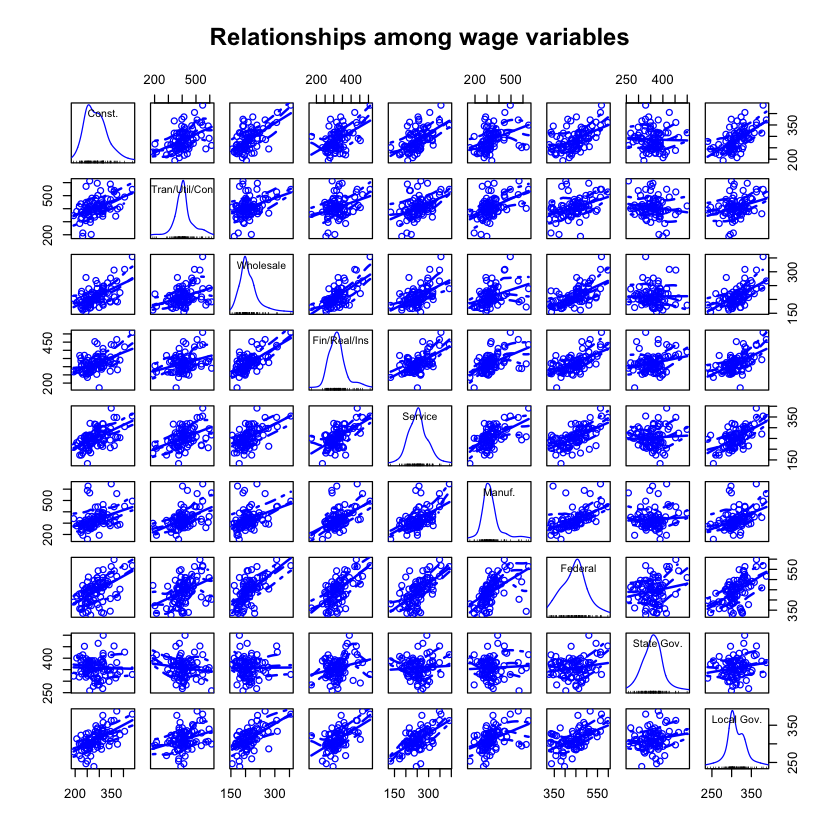

In [17]:
scatterplotMatrix(~wcon + wtuc + wtrd + wfir + wser + wmfg + wfed + wsta + wloc, 
                  data = logcrime, main = "Relationships among wage variables", 
                  var.labels=c("Const.", "Tran/Util/Con", "Wholesale",
                               "Fin/Real/Ins","Service",
                               "Manuf.","Federal","State Gov.","Local Gov."))

There does not appear to be any exact colinearity, but there does appear to be correlation. We examine the correlation matrix to see how large this is.

In [18]:
cor(logcrime[,c(13,14,15,16,17,18,19,20,21)])

,wcon,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc
wcon,1.00000000,0.4432933,0.577473384,0.5051639,0.5569705,0.38177286,0.5150461,-0.027064255,0.6012692
wtuc,0.44329328,1.0000000,0.351988290,0.3253013,0.4287211,0.45960866,0.4020310,-0.149317766,0.3123344
wtrd,0.57747338,0.3519883,1.000000000,0.6680122,0.5463144,0.37220597,0.6406744,0.008159654,0.5997546
wfir,0.50516386,0.3253013,0.668012227,1.0000000,0.5962259,0.49701629,0.6237379,0.242884981,0.5659871
wser,0.55697049,0.4287211,0.546314431,0.5962259,1.0000000,0.55124829,0.6091940,0.065939399,0.6091347
wmfg,0.38177286,0.4596087,0.372205972,0.4970163,0.5512483,1.00000000,0.5231767,0.058733721,0.4336387
wfed,0.51504607,0.4020310,0.640674380,0.6237379,0.6091940,0.52317673,1.0000000,0.188390863,0.5412372
wsta,-0.02706426,-0.1493178,0.008159654,0.2428850,0.0659394,0.05873372,0.1883909,1.000000000,0.1841068
wloc,0.60126916,0.3123344,0.599754640,0.5659871,0.6091347,0.43363869,0.5412372,0.184106773,1.0000000


Some of the pairs of wage variables have fairly high correlation, so we will not favor models that have all or a large number of these variables included. Just a few will suffice to account for the overall wage level in the county.

## Variable selection by Backwards Selection

To determine which variables are correlated with crime, we are going to do backwards selection of our model. The idea is to build a model with all the variables. Then, we will remove the variable that has the largest p-value, re-run the model and compare it to the previous model using the F-test, remove the variable that has the largest p-value, and so on until removing another variable weakens our F-statistic. 

Fortunately, the step() function in R will do this backwards selection for us, using the F-test to compare the newest model with the previous one like so:
1.  We will start with a base model with all variables.
2.  Run F-tests comparing all different models with one variable removed from the base model.
3.  Refit the model without the variable with the largest p-value, so long as the p-value for that variable is larger than .05 and the the F-statistic increases.
4.  Repeat steps 2-3 until deleting a variable will delete a significant variable and weaken our F-statistic.

A drawback to this method is that it relies only data and not on scientific or any other established knowledge in the field. However, we feel this is appropriate in this case because none of us are experts in criminology. 

In [19]:
m1 <- lm(log_crmrte ~ ., data = logcrime)

In [20]:
step(m1, direction="backward", test="F")

Start:  AIC=-202.43
log_crmrte ~ prbarr + prbconv + prbpris + avgsen + log_polpc + 
    log_density + log_taxpc + west + central + urban + pctmin80 + 
    wcon + wtuc + wtrd + wfir + wser + wmfg + wfed + wsta + wloc + 
    log_mix + log_pctymle

              Df Sum of Sq    RSS     AIC F value    Pr(>F)    
- log_taxpc    1   0.00545 5.4644 -204.34  0.0658  0.798281    
- prbconv      1   0.00620 5.4651 -204.33  0.0750  0.785077    
- wmfg         1   0.00973 5.4686 -204.28  0.1176  0.732758    
- wcon         1   0.01528 5.4742 -204.19  0.1848  0.668709    
- wsta         1   0.02644 5.4853 -204.00  0.3196  0.573740    
- wloc         1   0.05998 5.5189 -203.46  0.7251  0.397548    
- wtuc         1   0.11349 5.5724 -202.60  1.3722  0.245653    
- pctmin80     1   0.11992 5.5788 -202.50  1.4499  0.232843    
<none>                     5.4589 -202.43                      
- urban        1   0.17291 5.6318 -201.66  2.0906  0.152942    
- west         1   0.21393 5.6728 -201.01  2.5865 


Call:
lm(formula = log_crmrte ~ prbarr + prbpris + avgsen + log_polpc + 
    log_density + west + central + urban + wtrd + wfir + wser + 
    wfed + log_mix + log_pctymle, data = logcrime)

Coefficients:
(Intercept)       prbarr      prbpris       avgsen    log_polpc  log_density  
   2.559665    -1.082621    -0.607782    -0.036255     0.691947     0.119319  
       west      central        urban         wtrd         wfir         wser  
  -0.319797    -0.183172     0.261067     0.003125    -0.001585    -0.001769  
       wfed      log_mix  log_pctymle  
   0.002217     0.142843     0.372494  


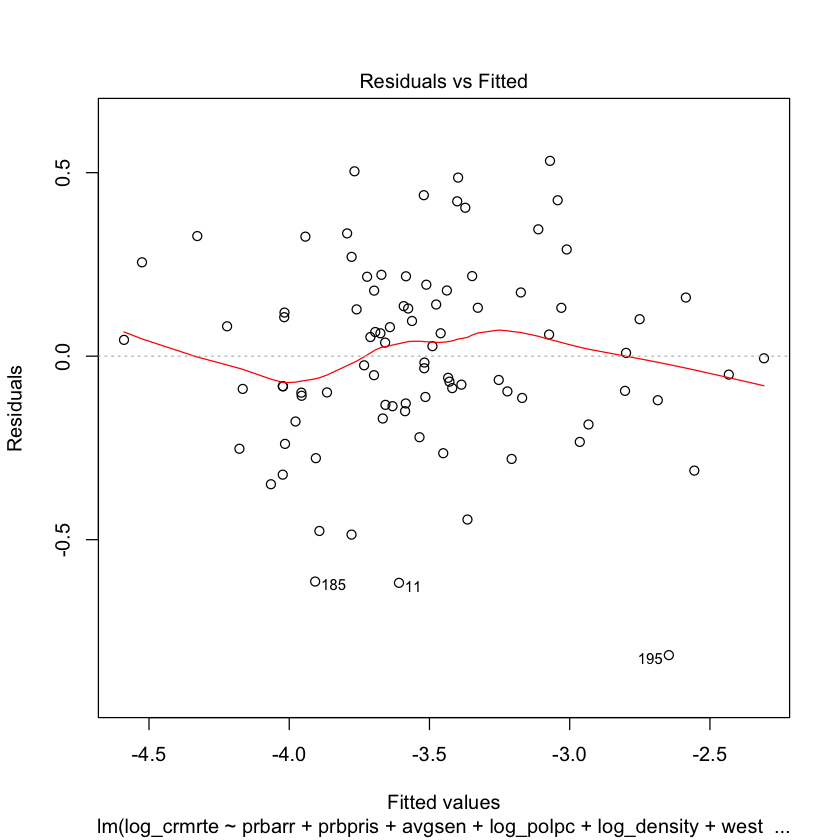

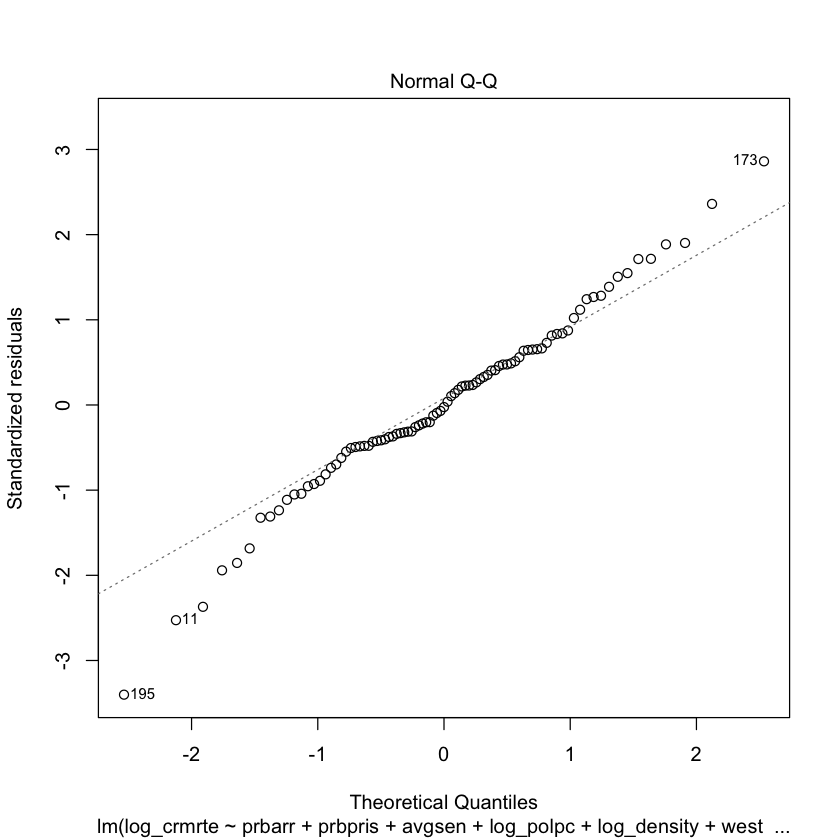

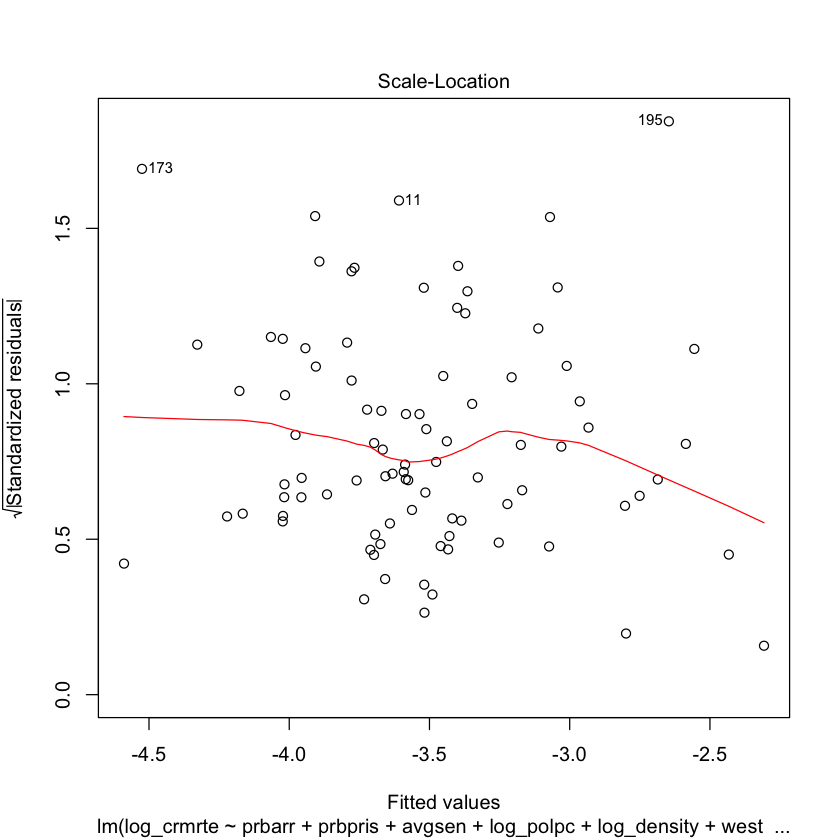

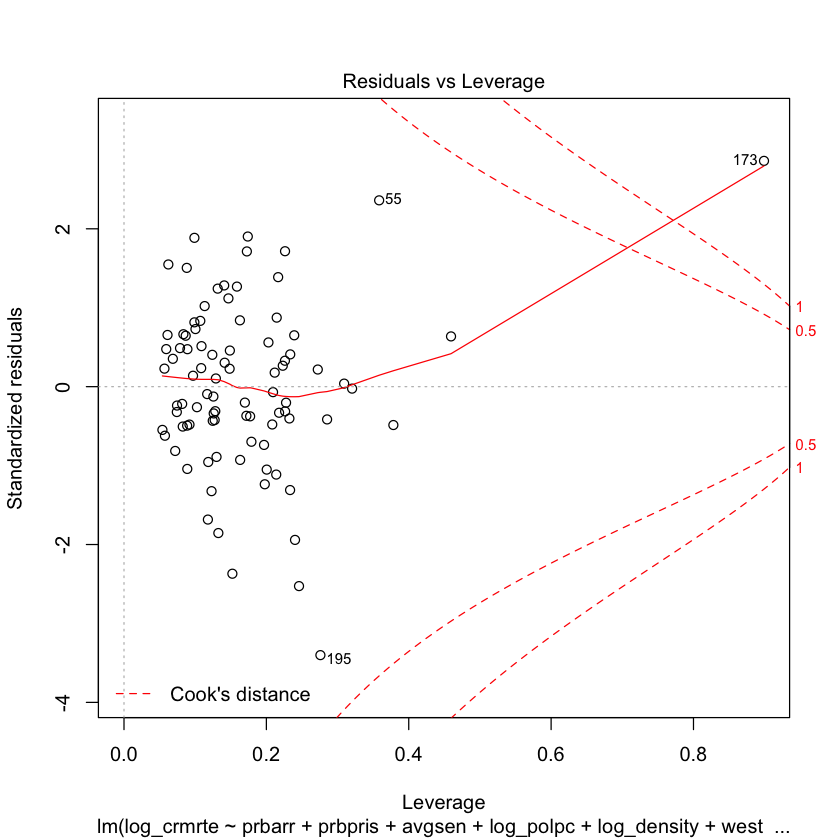

In [21]:
plot(lm(formula = log_crmrte ~ prbarr + prbpris + avgsen + log_polpc + 
    log_density + west + central + urban + wtrd + wfir + wser + 
    wfed + log_mix + log_pctymle, data = logcrime))

We note that county 173  (point 78) has a large Cook's distance. It also has a population density near zero, and a log that is nearly 8 standard deviations below the mean. If the county is that thinly populated, all of its statistics are called into question because of the small sample sizes. Even a single additional crime/arrest could have a big effect on the crime rate/probability of arrest. For this reason, we remove this data point from the data set and rerun our backwards selection.

In [22]:
m2 <- lm(log_crmrte ~ ., data = logcrime[-78,])
step(m2, direction="backward", test="F")

Start:  AIC=-212.71
log_crmrte ~ prbarr + prbconv + prbpris + avgsen + log_polpc + 
    log_density + log_taxpc + west + central + urban + pctmin80 + 
    wcon + wtuc + wtrd + wfir + wser + wmfg + wfed + wsta + wloc + 
    log_mix + log_pctymle

              Df Sum of Sq    RSS     AIC F value    Pr(>F)    
- prbconv      1   0.00000 4.6526 -214.71  0.0000  0.998268    
- wmfg         1   0.00020 4.6528 -214.71  0.0028  0.957894    
- wloc         1   0.01100 4.6636 -214.50  0.1537  0.696306    
- urban        1   0.01482 4.6674 -214.43  0.2070  0.650644    
- log_taxpc    1   0.03445 4.6870 -214.06  0.4812  0.490339    
- wsta         1   0.03595 4.6885 -214.03  0.5023  0.481037    
- wcon         1   0.03813 4.6907 -213.99  0.5327  0.468116    
- prbpris      1   0.09293 4.7455 -212.97  1.2982  0.258715    
<none>                     4.6526 -212.71                      
- wtuc         1   0.11209 4.7647 -212.62  1.5659  0.215286    
- wfed         1   0.12146 4.7740 -212.44  1.6969 


Call:
lm(formula = log_crmrte ~ prbarr + avgsen + log_polpc + log_density + 
    west + central + pctmin80 + wtuc + wtrd + wfir + wser + wfed + 
    log_mix + log_pctymle, data = logcrime[-78, ])

Coefficients:
(Intercept)       prbarr       avgsen    log_polpc  log_density         west  
  1.3665009   -1.0588956   -0.0252071    0.5563606    0.3634625   -0.2740753  
    central     pctmin80         wtuc         wtrd         wfir         wser  
 -0.2263759    0.0044536    0.0006486    0.0022252   -0.0017163   -0.0018229  
       wfed      log_mix  log_pctymle  
  0.0011828    0.1228953    0.2748621  


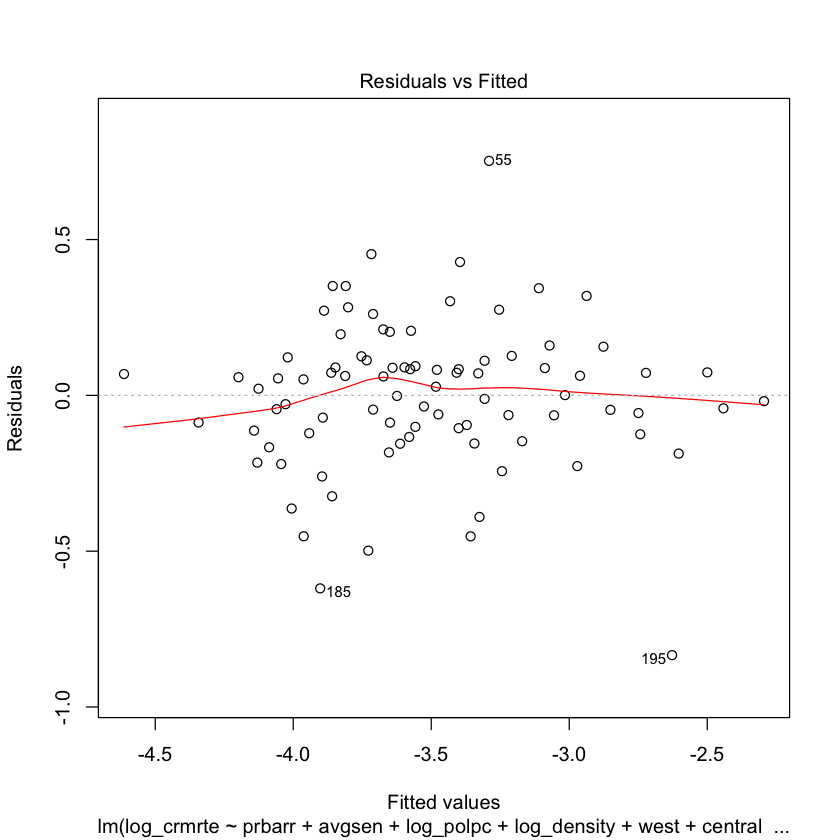

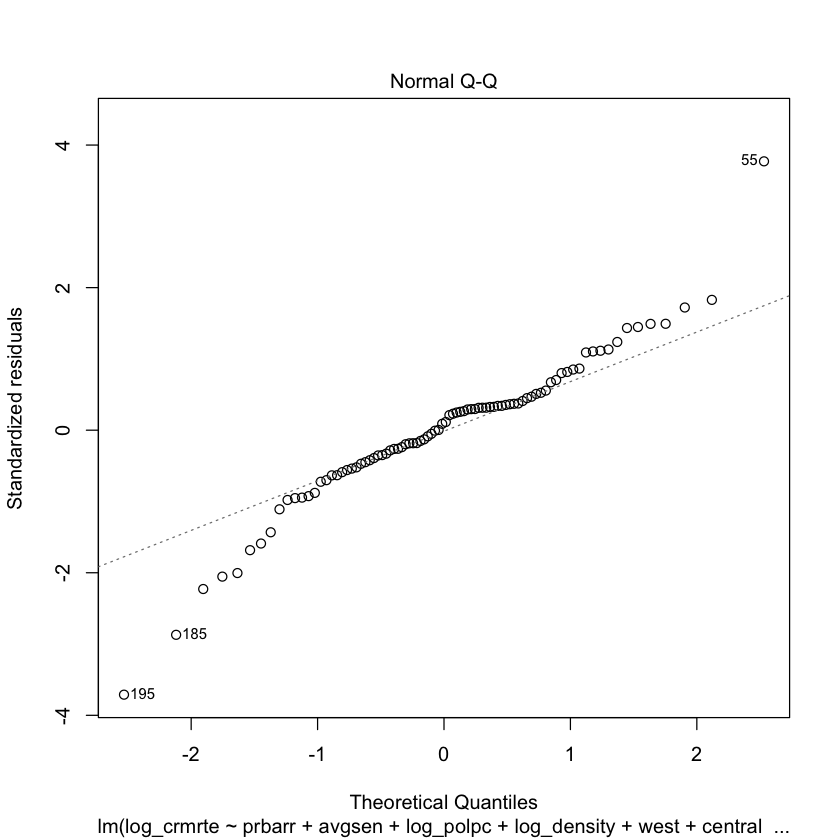

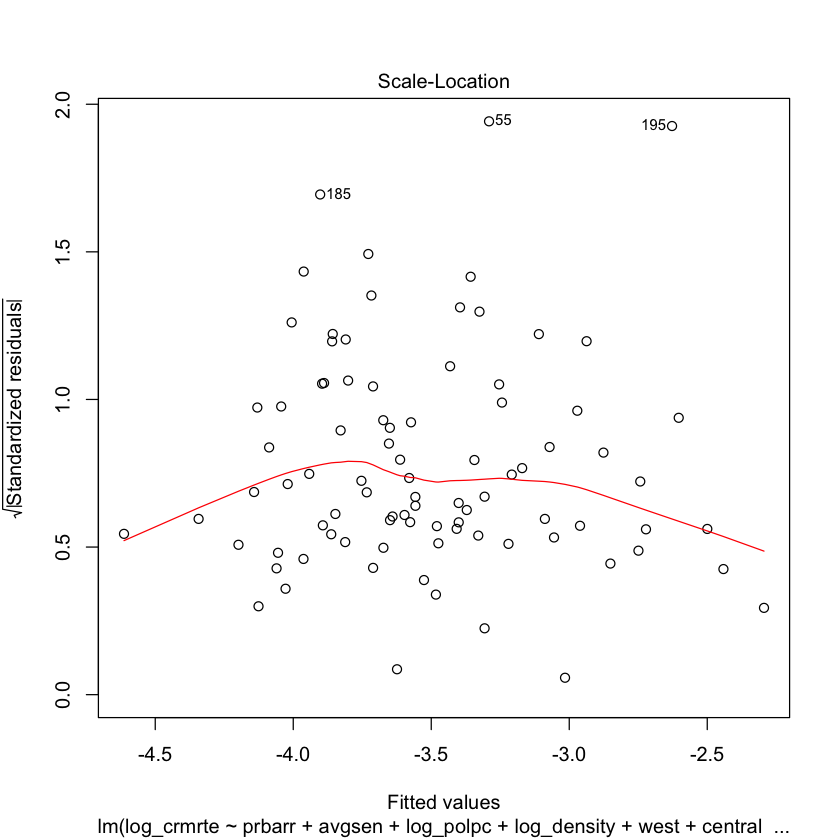

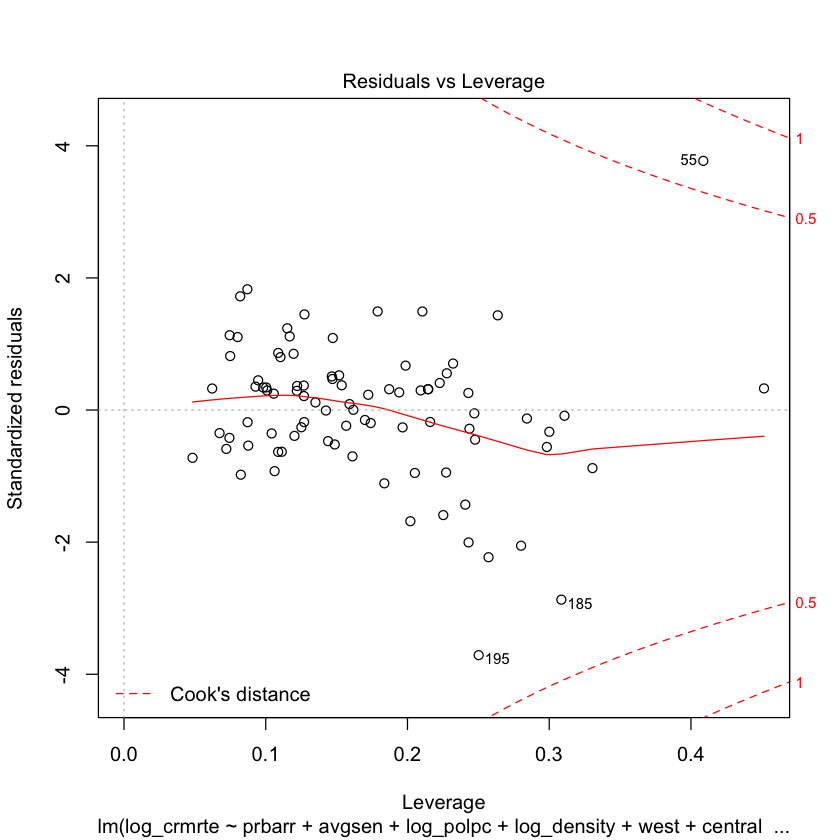

In [23]:
plot(lm(formula = log_crmrte ~ prbarr + avgsen + log_polpc + log_density + 
    west + central + pctmin80 + wtuc + wtrd + wfir + wser + wfed + 
    log_mix + log_pctymle, data = logcrime[-78, ]))

Removing point 78 has ensured that no point has too much leverage. We will perform further analysis of these plots below.

AIC is one method that can be used to balance minimizing R-squared with providing a penalty for adding a new variable. I.e., lower AIC indicates less information lost without overfitting. As we can see, this final model minimizes AIC. 
Below is our final model.

In [24]:
mfinal <- lm(formula = log_crmrte ~ prbarr + avgsen + log_polpc + log_density + 
    west + central + pctmin80 + wtuc + wtrd + wfir + wser + wfed + 
    log_mix + log_pctymle, data = logcrime[-78, ])
summary(mfinal)


Call:
lm(formula = log_crmrte ~ prbarr + avgsen + log_polpc + log_density + 
    west + central + pctmin80 + wtuc + wtrd + wfir + wser + wfed + 
    log_mix + log_pctymle, data = logcrime[-78, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.83355 -0.11522  0.02452  0.11142  0.75247 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.3665009  0.8928799   1.530  0.13023    
prbarr      -1.0588956  0.3322860  -3.187  0.00212 ** 
avgsen      -0.0252071  0.0123619  -2.039  0.04506 *  
log_polpc    0.5563606  0.1157536   4.806 8.00e-06 ***
log_density  0.3634625  0.0640730   5.673 2.66e-07 ***
west        -0.2740753  0.1086094  -2.523  0.01380 *  
central     -0.2263759  0.0768799  -2.945  0.00434 ** 
pctmin80     0.0044536  0.0026286   1.694  0.09448 .  
wtuc         0.0006486  0.0004369   1.484  0.14198    
wtrd         0.0022252  0.0013241   1.681  0.09713 .  
wfir        -0.0017163  0.0007831  -2.192  0.03159 *  
wser        -0.0018229  

In [25]:
coeftest(mfinal, vcov = vcovHC(mfinal, type = "HC0")) #heteroskedastic robust analysis


t test of coefficients:

               Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)  1.36650088  1.46659430  0.9318 0.3545365    
prbarr      -1.05889560  0.26442948 -4.0045 0.0001479 ***
avgsen      -0.02520711  0.00947781 -2.6596 0.0096108 ** 
log_polpc    0.55636057  0.22945486  2.4247 0.0177962 *  
log_density  0.36346248  0.04802061  7.5689 9.065e-11 ***
west        -0.27407532  0.13684212 -2.0029 0.0489063 *  
central     -0.22637590  0.08425811 -2.6867 0.0089301 ** 
pctmin80     0.00445359  0.00345771  1.2880 0.2018082    
wtuc         0.00064859  0.00049610  1.3074 0.1951828    
wtrd         0.00222521  0.00115320  1.9296 0.0575441 .  
wfir        -0.00171633  0.00067764 -2.5328 0.0134645 *  
wser        -0.00182288  0.00079227 -2.3008 0.0242601 *  
wfed         0.00118276  0.00081938  1.4435 0.1531644    
log_mix      0.12289527  0.07147978  1.7193 0.0897974 .  
log_pctymle  0.27486207  0.14609327  1.8814 0.0639028 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*

Our final model contains the following variables: prbarr (probability of arrest), avgsen (avergage sentence length), log_polpc (log of police per capita), log_density (log of population density), west (indicator for county in the west), central (indicator for county in the center of the state), pctmin80 (percent minority), wtuc (transportation/utility wage), wtrd (wholesale wage), wfir (finance wage), wser (service wage), wfed (federal employee wage), log_mix (log of the crime mix). We believe that our explanatory variables are probability of arrests and average sentence length. We are controlling for police per capita, density, whether the county is in the west or central, the various wages, and mix of the crimes.

This is in line with our understanding of the variables. Having a higher probability of arrest will naturally deter criminals from committing crimes in the first place from the fear of getting caught and serving time. On top of that, increasing the penalty of crimes (having longer sentences) will deter criminals from committing crimes. Police per capita is controlled for to atone for the fact that having more police increases the rate of crime, since there are more officers to detect crime. Density is controlled for as well, since denser counties have more people, making crime more probable. West and central are controlled for to remove any locational biases that may arise. The wage data variables are indicative of the salary of the county, since wages are based on the cost of living of the specific city/area they reside in. We control for the mix of crime, because a higher mix of crime means that there are more face to face crimes. The police may be more inclined to go after face to face crimes as opposed to petty thefts, for example, so we are controlling for that effect to ensure that our explanatory variables are not related to the error term. We control for the percentage of young males, because that is the most commonly implicated demographic in crime. We also control for the percent minority because of the possibility of correlation between minority status and the probability of arrest, regardless of whether crimes were committed.

## Statistical Significance
To determine significance, we use the heteroskedastic robust tools from above for reasons stated in our CLM assumptions below.

The null hypothesis for each term in the regression equation is that the coefficient has no effect on the dependent variable (the coefficient equals 0). Looking at our model 2, we can see that our explanatory variables, probability of arrest and average sentence, have very low p-values of 0.0001479 and 0.0096108 respectively, indicating high statistical significance. We therefore reject the null hypothesis that the coefficients are equal to 0, making them more likely to be associated with our response variable. Analyzing the variables that we control for, police per capita and density both have low p-values of 0.0177962 and essentially 0 respectively, indicating very high statistical significance. We, therefore, reject the null hypothesis, making them more likely to be associated with our response variable. Similarly, we reject the null hypothesis for west, central, and wfir which all have statistically significant p-values of 0.0489063, 0.0089301, and 0.0134645. Wtuc, pctmin80, wtrd, wfed, mix, and pctymle all have p-values greater than 0.05, meaning we fail to reject the null hypothesis. However, we believe these variables are meaningful additions to the model, because they capture relationships between explanatory variables and control variables that may otherwise confound the regression.

Therefore, model 1 will contain only the explanatory variables, model 2 will contain the explanatory variables plus the variables we control for, and the final model contains all variables. 

In [26]:
model1 <- lm(log_crmrte ~ prbarr + avgsen, data = logcrime[-78,])
model2 <- mfinal
model3 <- lm(log_crmrte ~ ., data = logcrime[-78,])
stargazer(model1, model2, model3, title="Summary of Models", align=TRUE, type = "text")
AIC(model1, model2, model3)


Summary of Models
                                             Dependent variable:                         
                    ---------------------------------------------------------------------
                                                 log_crmrte                              
                             (1)                    (2)                     (3)          
-----------------------------------------------------------------------------------------
prbarr                    -1.665***              -1.059***               -1.121***       
                           (0.497)                (0.332)                 (0.354)        
                                                                                         
prbconv                                                                   0.0005         
                                                                          (0.227)        
                                                                                 

,df,AIC
,<dbl>,<dbl>
model1,4,129.94713
model2,16,27.82962
model3,24,39.02059


By design, our second model shows the strongest F-statistic and the lowest AIC (which makes sense, because these are the critera we used to select it). 
- The significant F-statistic indicates that each of our models are more informative than the intercept-only model. Here, model 2 has the strongest significance for the F-statistic. 
- A small AIC means that we have balanced retained information with overfitting. Here, model 2 has the best balance.
- Model 2 has the highest adjusted R-squared, another indicator that we have balanced retained information with overfitting. 

From model 1 to model 2, as we include the variables we are controlling for, the probability of arrest coefficient increases, indicating that we are accounting for relationships omitted from model 1. In model 2 to model 3, the coefficient decreases, the F-statistic and adjusted R-squared decreases, and AIC increases indicating that model 3 was overfitted. 

We expected a negative relationship between average sentence and crime rate; however, in model 1, it was positive and not significant. After including our control variables, the relationship became negative and significant, meaning we accounted for an omitted relationship that was masking the effect of average sentence. Then from model 2 to model 3, the coefficient did not change very much, indicating that model 2 is robust to the effect of adding variables.

The above leads us to conclude that model 2 is the best model. 

## Omitted Variables

1. We are controlling for police per capita since it is correlated with crime rate. But, we are introducing a bias where more police naturally increases the crime rate (since more police means more people who must report crimes, and there is more general promotion to report crimes). We think this push to report crimes increases the crime rate. 

2. We do not have data for unreported crime. If we truly knew about every crime that was commited, that would change the outcome of our model. If we knew about all unreported crimes, it would increase our crime rate. We also believe that these unreported crimes are of a different nature. For example, someone is more likely to report a murder than a pickpocket. This could change the way our variables interact with crime rate. 

3. Police effectiveness is not directly measured. For example, police may be less inclined to work in low income areas where the crime rate has a reputation for being higher. This could result in dissatisfaction of the employed officers, which may lead to a decline in the quality of work the officer does. Perpetrators might be more inclined to commit more crimes with less vigilance of officers. This would have a negative impact because as quality of police increases, the crime rate decreases. 

4. In counties with high police presence the crime rate tends to be higher. This could be because the added police presence encourages people to report crimes. However, in counties with low police presence, people may feel they will not be helped anyways, so do not report crimes.  We think this desire to report crimes increases the crime rate. 

5. Environmental variables such as weather can affect crime rates, but we do not have climate data. Hotter counties will have higher crime rates. 

6. We do not know the ratios of wages in an area. Although wage is included in this dataset, we cannot assume that the wages are equally spread (i.e. it is not accurate to assume that every county has the same ratio of people in finance, retail, etc.). We believe that areas with lower overall wage probably have higher crime rates. 

7. We do not have unemployement rate data. We think that higher unemployement would lead to a higher rate of petty crime or theft. 

8. We do not have any data about education levels of people in counties. Although this can be correlated with wage, we believe that an increase in education leads to a decrease in crime rate, even when holding wage constant.

Even with these omitted variables, we believe that probability of arrest and average sentence are still valid variables, because probability of arrest and average sentence are fairly independent from the listed omitted variables. If an effect was omitted, it should be fairly slight when it comes to affecting the coefficients of these variables. However, there are two variables that we think may have a slight effect on probability of arrest:

1. If all unreported crimes were reported, but not arrested, that would reduce the crime rate. However, it is reasonable to think that more reported crimes would lead to more arrests. It is hard to say how exactly this would affect probability of arrest. For the purpose of this report, we will assume the affect is negligible. 

2. The police per capita may effect probability of arrest. To check this, we will look at covariance.


In [27]:
cov(logcrime$prbarr, logcrime$log_polpc)
cor(logcrime$prbarr, logcrime$log_polpc)

[1] -0.004769033

[1] -0.1341231

Probability of arrest and police per capita have a low covariance and correlation. This implies that they have little relationship. Therefore, an increase in police per capita does not imply an increase in probability of arrest. With this information, we think that probability of arrest is a valid explanitory variable.


### Practical Significance

In [28]:
cohen.d(logcrime$log_crmrte, logcrime$prbarr, na.rm = TRUE)
cohen.d(logcrime$log_crmrte, logcrime$avgsen, na.rm = TRUE)


Cohen's d

d estimate: -10.09228 (large)
95 percent confidence interval:
     lower      upper 
-11.188577  -8.995984 


Cohen's d

d estimate: -6.993916 (large)
95 percent confidence interval:
    lower     upper 
-7.783017 -6.204815 

In model 2 (the model we are choosing to use), increasing the probablity of arrest by 1 percent will decrease the crime rate by 1.059 percent. This is statstically significant with a p-value <.01.

Increasing the average sentence decreases the crime rate by 2.5 percent.  This is statistically significant with a p-value <.05.

We have tested for practical significance of the prbarr and avgsen on crmrte using Cohen's d. Our Cohen's d is quite large for both of them, indicating there is large practical significance here.

### Standardized coefficients
It would be interesting to know the relative effects of coefficients used in the model. That is, after accounting for the natural variability (variance) of each variable, which are the largest coefficients? To answer this, we standardize the cofficients using the beta function.

In [29]:
lm.beta(mfinal)

prbarr      avgsen   log_polpc log_density        west     central 
-0.21709992 -0.12571593  0.34121829  0.53459613 -0.22242167 -0.21345397 
   pctmin80        wtuc        wtrd        wfir        wser        wfed 
 0.14557094  0.09324537  0.14581877 -0.17929811 -0.15502032  0.13551319 
    log_mix log_pctymle 
 0.12662254  0.10583892

The population density (log_density) has the greatest effect, with a one standard deviation increase in density leading to over a half standard deviation increase in crime. This is not surprising, given that greater density means people would interact more and that there would be more opportunity for crime. This is one of the reasons we included it as a control variable. Police per capita (polpc), another control variable, has the second greatest effect, with a one standard deviation increase of police leading to about a third of a standard deviation increase in crime. The value for probability of arrest (prbarr) is among the higher valued standardized coefficients, accounting for about a twenty percent decrease in crime in terms of standard deviations. We consider it our primary explanitory variable. Our other explanitory variable, the average sentence length (avgsen), has a lower effect, accounting for about a twelve percent decrease in crime in terms of standard deviations. However, this is higher than the beta value of some of the control variables in the model, so we still consider its impact on crime to be important.

## CLM Assumptions

Below is our final model. We will test for the 6 assumptions of CLM. 

In [30]:
summary(mfinal)


Call:
lm(formula = log_crmrte ~ prbarr + avgsen + log_polpc + log_density + 
    west + central + pctmin80 + wtuc + wtrd + wfir + wser + wfed + 
    log_mix + log_pctymle, data = logcrime[-78, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.83355 -0.11522  0.02452  0.11142  0.75247 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.3665009  0.8928799   1.530  0.13023    
prbarr      -1.0588956  0.3322860  -3.187  0.00212 ** 
avgsen      -0.0252071  0.0123619  -2.039  0.04506 *  
log_polpc    0.5563606  0.1157536   4.806 8.00e-06 ***
log_density  0.3634625  0.0640730   5.673 2.66e-07 ***
west        -0.2740753  0.1086094  -2.523  0.01380 *  
central     -0.2263759  0.0768799  -2.945  0.00434 ** 
pctmin80     0.0044536  0.0026286   1.694  0.09448 .  
wtuc         0.0006486  0.0004369   1.484  0.14198    
wtrd         0.0022252  0.0013241   1.681  0.09713 .  
wfir        -0.0017163  0.0007831  -2.192  0.03159 *  
wser        -0.0018229  

#### 1: Linearity

There is no way to check for linearity because we can't look at our population. However, there is no need to check for linearity because we have not yet constrained our error term. Therefore, our model can be linear no matter what as long as we are okay with a poorly behaved error term. Thus, it is okay to assume linearity. 

#### 2: Random Sampling
To test for random sampling, we must know how our data is collected. Here, we know that each data point represents a county, but how were the counties selected? For example, did we pull every county from the state, did we choose convenient counties, or is it a truly random selection from the state? If the data is taken from a random selection of counties, then we can assume random sampling. Because we don't know that this is the case, we can't assume that this data is represenative of all counites. 

If we cannot assume random sampling, we may have issues with clustering. For example, state policies may have an impact on crime rate. If we knew this were the case, we would still know that the coefficients are unbiased, though less precise. 

This is not time-series data which leads us to believe that the data is not autocorrelated. It is possible that one county may have effects on nearby counties, and we don't know if these counties are neighbors or not. For the sake of this assignment, we will assume that the counties were randomly sampled and therefore not autocorrelated.

#### 3: Multicollinearity
When we run the model, if we have variables that are perfectly collinear, R will throw an error. In this case, there is no error when we run our model, so it is safe to assume that our model has no perfect collinearity. Also, the scatterplots revealed no perfect linear relationships.

#### 4: Zero-Conditional Mean
Looking at the residual vs. fitted plot, we see that the red line is flat enough around zero, indicating a zero-conditional mean. 

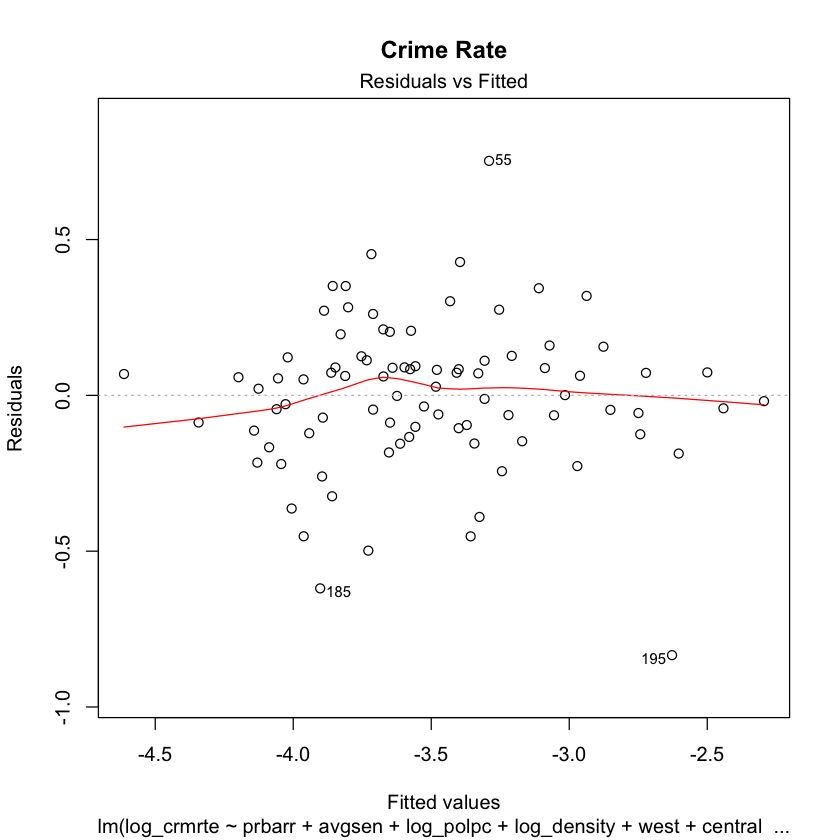

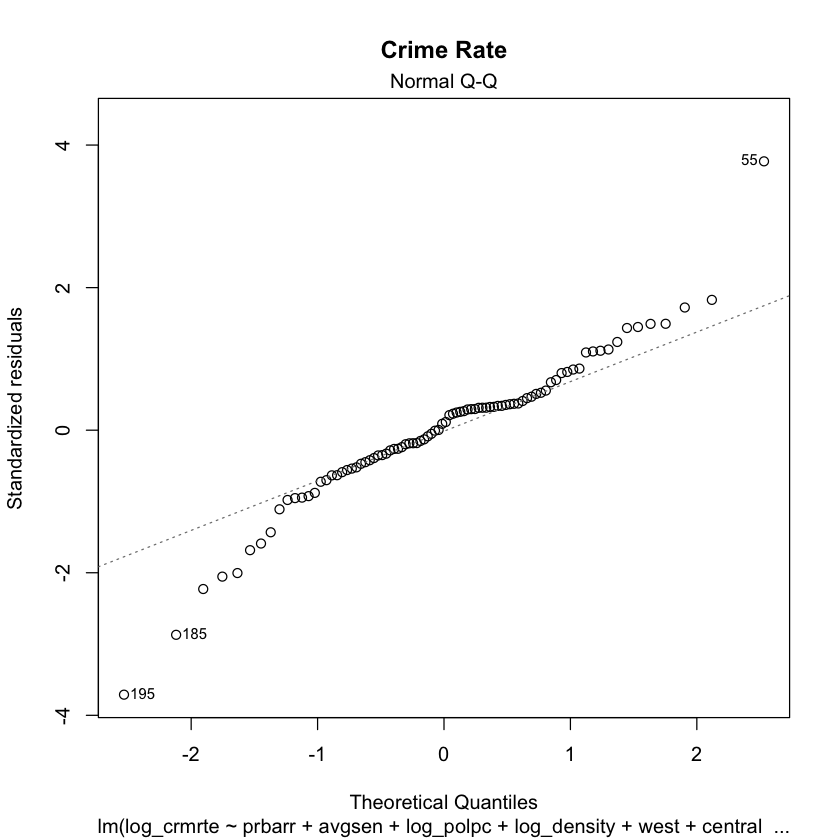

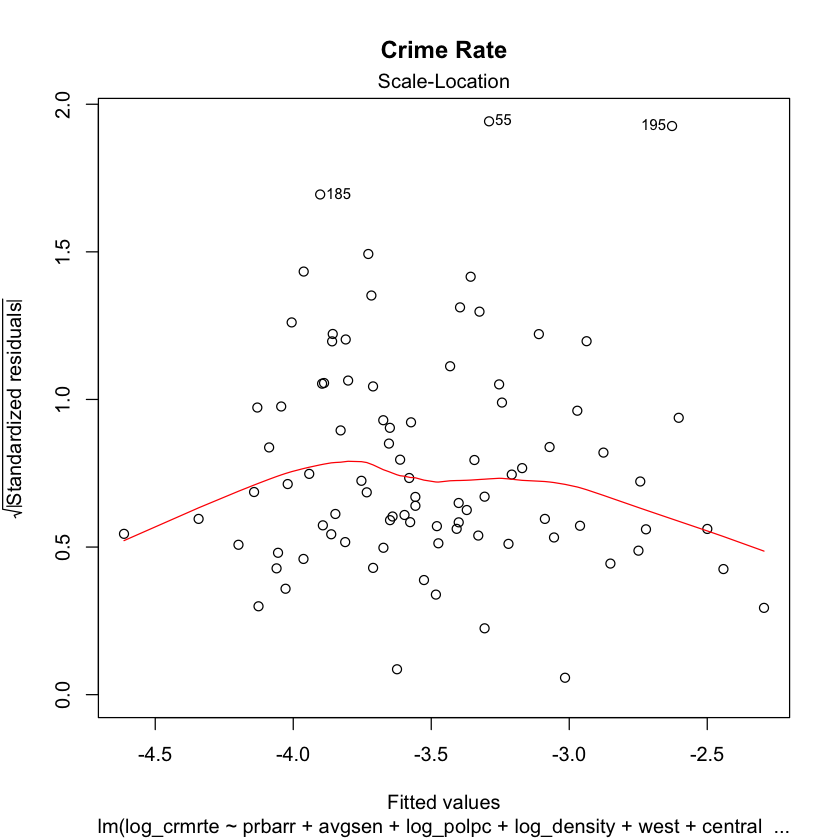

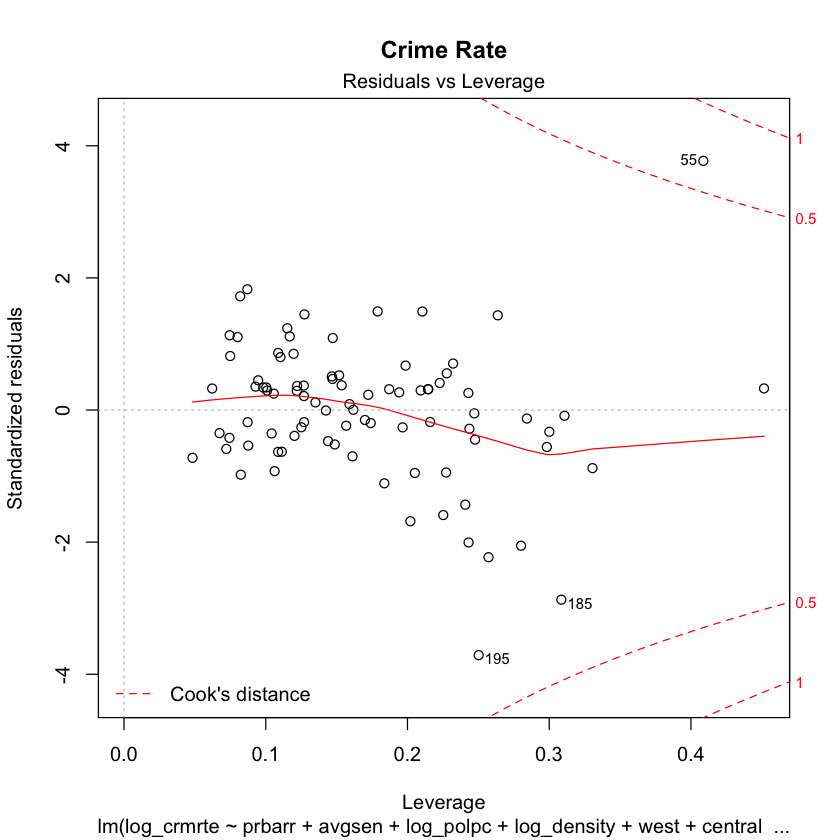

In [31]:
plot(mfinal, main="Crime Rate")

#### 5: Homoskedasticity

In a homeskedatic model, our errors should be uniform around the red line in the residual vs. fitted plot, which appears to be the case. We can confirm homoskedasticity by showing that the results of the Breush-Pagan Test are not significant (p > .05).

In [32]:
bptest(mfinal)


	studentized Breusch-Pagan test

data:  mfinal
BP = 39.406, df = 14, p-value = 0.0003156


We can see that our p-value is less than .05. This indicates heteroskedasticity. This could be due to actual heteroskedasticity, or to large sample size (this test tends to come up significant for large samples). To be certain, we used heteroskedastic robust tools, which work for homoskedastic models; they are just more conservative. As shown above, the robust t-test results show significance of the coefficients of our explanitory variables.

#### 6: Normality of Error Terms

We can see from the Normal QQ plot above that the values mostly tend to follow the normal line, but there may be some non-normality at the extreme values. However, even if the extreme values are non-normal, we can rely on the asymptotic properties of OLS because we have a large sample size. Therefore, we will assume that our error term is normal.

## Policy Suggestion

Our models indicate a negative relationship between the probability of arrest and the length of sentences. Presumably, in counties where arrest rates are higher and sentences are longer, people are less inclined to commit crimes. Therefore, our policy suggestions revolve around increasing the arrest rate and length of sentences, or at least increasing the *perceived* values of these variables.

There are three ways to go about doing this:
1. The most obvious way to increase the number of arrests is to increase the number of police. However, our model indicates that there is a positive relationship between the police per capita and the crime rate. There is also little correlation between police per capita and probability of arrest. Therefore, we must be wary of simply increasing the number of police.
2. Better training and tools for police can improve their efficiency in making arrests without actually increasing the number of police. This could come in the form of subsidized tuition for criminology courses or better gear such as body cams, for example. This can be costly, but beneficial.
3. Since the reduction in crime appears to be related to the perception of bad outcomes from crime, our proposal is to increase the perceived arrest rate and sentence length. This can be a low-cost solution.

#### How can we increase the perceived arrest rate?
- When someone is arrested, make it public: post it in newspapers and on local news stations.
- Intentionally take data out of context: "We arrested 50 people this month for x crime." That may only be 10%, but it can sound like a lot to someone who is thinking of commiting a crime.

#### How can we increase the perception of average sentence lengths?
- Publicize the average sentence length for each crime
- Publicize convictions that have a long sentence
- Highlight the pain and expense involved in going through the criminal justice system

We believe that by increasing the perceived drawbacks of committing a crime, we will reduce the overall crime rate.